## Machine Learning (classification)


[![](https://raw.githubusercontent.com/ploomber/ploomber/master/_static/open-in-jupyterlab.svg)](https://binder.ploomber.io/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fmicro-pipelines%252Fml-classification.ipynb%26branch%3Dmaster)

*Note: the micro-pipelines API was added in Ploomber 0.21*

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn_evaluation import plot
import matplotlib.pyplot as plt

from ploomber.micro import dag_from_functions, grid

## Declare steps

In [3]:
def data():
    data = datasets.make_classification(1000, 10, n_informative=5,
                                        class_sep=0.80)
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    return X_train, X_test, y_train, y_test

def features(data):
    X_train, X_test, y_train, y_test = data
    poly = PolynomialFeatures()
    X_train_feats = poly.fit_transform(X_train)
    X_test_feats = poly.transform(X_test)
    return X_train_feats, X_test_feats, y_train, y_test, poly

def scaled(features):
    X_train, X_test, y_train, y_test, _ = features
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    return X_train_norm, X_test_norm, y_train, y_test, scaler

@grid(model=[RandomForestClassifier],
      n_estimators=[50, 100, 200],
      criterion=["gini", "entropy"],
)
def fit_random_forest(scaled, model, n_estimators, criterion):    
    X_train, X_test, y_train, y_test, _ = scaled
    clf = model(n_estimators=n_estimators, criterion=criterion)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return dict(clf=clf, acc=acc)

@grid(model=[AdaBoostClassifier],
      n_estimators=[50, 100, 200],
      learning_rate=[1.0, 2.0],
)
def fit_ada_boost(scaled, model, n_estimators, learning_rate):    
    X_train, X_test, y_train, y_test, _ = scaled
    clf = model(n_estimators=n_estimators, learning_rate=learning_rate)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return dict(clf=clf, acc=acc)

## Plot pipeline

In [4]:
dag = dag_from_functions([data, features, scaled, fit_random_forest, fit_ada_boost])

  0%|          | 0/15 [00:00<?, ?it/s]

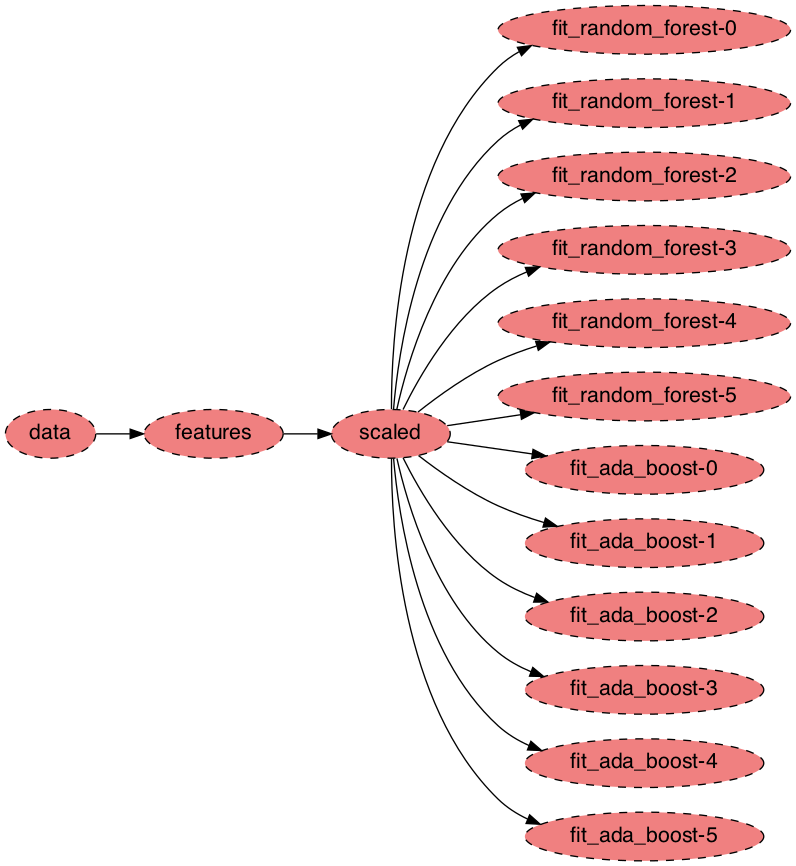

In [5]:
dag.plot()

## Run

In [6]:
dag.build()

  0%|          | 0/15 [00:00<?, ?it/s]

name,Ran?,Elapsed (s),Percentage
data,True,0.038992,0.5138
features,True,0.00377,0.0496775
scaled,True,0.00622,0.0819613
fit_random_forest-0,True,0.191089,2.51799
fit_random_forest-1,True,0.2449,3.22706
fit_random_forest-2,True,0.398946,5.25694
fit_random_forest-3,True,0.490001,6.45678
fit_random_forest-4,True,0.733074,9.65976
fit_random_forest-5,True,0.983161,12.9552
fit_ada_boost-0,True,0.31566,4.15947


## Sort models by performance

In [7]:
outputs = [task.load() for name, task in dag.items() if name.startswith('fit_')]

In [8]:
for out in sorted(outputs, key=lambda k: k['acc'], reverse=True):
    print(f'{out["clf"]}: {out["acc"]:.2f}')

RandomForestClassifier(criterion='entropy'): 0.89
RandomForestClassifier(criterion='entropy', n_estimators=200): 0.89
RandomForestClassifier(criterion='entropy', n_estimators=50): 0.88
AdaBoostClassifier(): 0.88
RandomForestClassifier(n_estimators=50): 0.88
RandomForestClassifier(n_estimators=200): 0.88
RandomForestClassifier(): 0.88
AdaBoostClassifier(n_estimators=100): 0.87
AdaBoostClassifier(n_estimators=200): 0.86
AdaBoostClassifier(learning_rate=2.0): 0.62
AdaBoostClassifier(learning_rate=2.0, n_estimators=100): 0.61
AdaBoostClassifier(learning_rate=2.0, n_estimators=200): 0.60
